In [1]:
%run "~/alignment_accuracy/alignment_accuracy_functions.ipynb"

In [2]:
#pairwise-bootstrapping?
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 

alphabet = {"-":0, "A": 1, "R": 2, "N":3, "D":4, "C":5, "Q":6, "E":7, "G":8,
            "H":9, "I":10, "L":11, "K":12, "M":13, "F":14, "P":15, 
            "S":16, "T":17, "W":18, "Y":19, "V":20, "X":21}
inverse_alphabet = {alphabet[x]:x for x in alphabet}

import math
INF = math.inf

import random

from Bio import Align

from IPython.display import clear_output

In [3]:
run_name = "PF00413_rp15_muscle"

In [4]:
make_shorter = False

if make_shorter:
    seqDictTemp = {}
    with open("pl8_seed_eros.fasta") as f:
        cur = ""
        for line in f:
            if line[0] == ">":
                cur = line[1:].strip()
                seqDictTemp[cur] = ""
            else:
                seqDictTemp[cur] += line.strip().replace("X","-")

    count = 0
    with open("pl8_seed_eros_short.fasta", 'w') as out:
        for seq in seqDictTemp:
            if len(seqDictTemp[seq]) <= 1000:
                count += 1
                out.write(">" + seq + "\n" + seqDictTemp[seq] + "\n")

    print(count)

In [5]:
#alignment_file = "test.afa"
alignment_file = run_name + ".afa"

max_num_seqs = INF
max_seq_len = INF

seqDict = file_to_seq_dict(alignment_file)

#with open(alignment_file) as f:
#    cur = ""
#    for line in f:
#        if line[0] == ">":
#            if len(seqDict) > max_num_seqs:
#                break
#            cur = line[1:].strip()
#            seqDict[cur] = ""
#        else:
#            seqDict[cur] += line.strip().replace("X","-")

for seq in seqDict.copy():
    if len(seqDict[seq]) > max_seq_len:
        seqDict.pop(seq)
        
alignment_len = max([len(x) for x in list(seqDict.values())])
num_seqs = len(seqDict)
mean_seq_len = np.mean([len(x.replace("-","")) for x in list(seqDict.values())])

print("Fasta processed. Converting to matrix.")

sequence_matrix, labels = seq_dict_to_matrix(seqDict)

#labels = np.empty((num_seqs, 1), dtype=object)
#sequence_matrix = np.empty((num_seqs, alignment_len), dtype=object)
#i = 0
#for label in seqDict:
#    labels[i, 0] = label
#    seq = seqDict[label]
#    sequence_matrix[i] = np.array([x.strip() for x in seq])
#    i += 1

print("\n", num_seqs, "sequences loaded.\n", alignment_len, "sites.\n", round(mean_seq_len, 2), "average length.")

Fasta processed. Converting to matrix.

 1860 sequences loaded.
 872 sites.
 139.21 average length.


(1860, 872)


(0.0, 100.0)

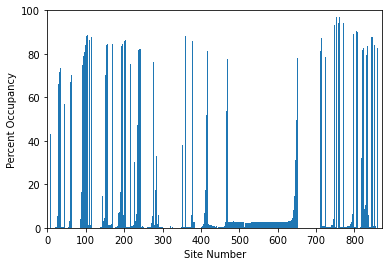

In [6]:
#print(list(sequence_matrix[0,:]))
print(sequence_matrix.shape)
occupancy = [(100 * np.count_nonzero(sequence_matrix[:, x] != "-") / num_seqs) for x in range(alignment_len)]
#print(occupancy)
plt.bar(list(range(alignment_len)), occupancy, align='edge', width=1)
plt.xlabel("Site Number")
plt.ylabel("Percent Occupancy")
plt.xlim(0, alignment_len)
plt.ylim(0, 100)

149 / 872 sites with > 50% occupancy


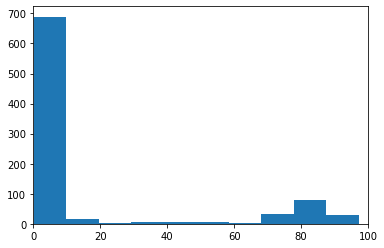

In [7]:
plt.hist(occupancy, bins=10)
plt.xlim(0,100)
print(len([x for x in occupancy if x>50]), "/", len(occupancy), "sites with > 50% occupancy")
#print(len([x for x in occupancy if x==min(occupancy)]), "/", len(occupancy), "singleton sites")

In [ ]:
n_shuffles = 300

alphabet_size = len(alphabet)
aligner = Align.PairwiseAligner()
aligner.mode = "global"
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")
aligner.extend_gap_score = 0
aligner.open_gap_score = -4

frequencies = [None] * num_seqs

for s in range(n_shuffles):
    indices = list(range(num_seqs))
    random.shuffle(indices)
    for p in range(0, num_seqs - 1, 2):
        clear_output(wait=True)
        print("Shuffle round:", s,", Pairing" , p // 2, "/", num_seqs // 2)
        ind_a = indices[p]
        ind_b = indices[p + 1]
        #print(ind_a, ind_b)
        seq_a = "".join(list(sequence_matrix[ind_a, :])).replace("-", "")
        seq_b = "".join(list(sequence_matrix[ind_b, :])).replace("-", "")
        alignments = aligner.align(seq_a, seq_b)
        #print(alignments[0])
        #print(alignments[0].aligned)
        alignment_regions = alignments[0].aligned
        #if p == 0:
        #    print(alignments[0])
        
        freq_a = np.zeros((len(seq_a), alphabet_size))
        freq_b = np.zeros((len(seq_b), alphabet_size))
        for i in range(len(alignment_regions[0])):
            seq_a_start, seq_a_end = alignment_regions[0][i]
            seq_b_start, seq_b_end = alignment_regions[1][i]
            chunk_size = seq_a_end - seq_a_start
            #print(ind_a,ind_b,chunk_size)
            for j in range(chunk_size):
                a_site_ind = seq_a_start + j
                b_site_ind = seq_b_start + j
                a_site = seq_a[a_site_ind]
                b_site = seq_b[b_site_ind]
                freq_a[a_site_ind, alphabet[b_site]] = 1
                freq_b[b_site_ind, alphabet[a_site]] = 1
        
        for i in range(len(seq_a)):
            if np.sum(freq_a[i,:]) == 0:
                freq_a[i, alphabet["-"]] = 1
                
        for i in range(len(seq_b)):
            if np.sum(freq_b[i,:]) == 0:
                freq_b[i, alphabet["-"]] = 1
        
        if not np.any(frequencies[ind_a]):
            frequencies[ind_a] = freq_a
        else:
            frequencies[ind_a] += freq_a

        if not np.any(frequencies[ind_b]):
            frequencies[ind_b] = freq_b
        else:
            frequencies[ind_b] += freq_b

In [8]:
if run_name+"_300x.npz" not in os.listdir():
    print("a")
    #np.savez('PF00413_rp15_muscle_300x.npz', *frequencies)

ERROR! Session/line number was not unique in database. History logging moved to new session 648


In [9]:
container = np.load(run_name + '_300x.npz')
frequencies = [container[key] for key in container]
frequenciesNorm = [x / (np.max(np.sum(x, axis=1))) for x in frequencies]

In [10]:
print(frequencies[0])
#print(np.mean(frequencies[0], axis=0))
#print(np.sum(frequencies[0], axis=1))
print(np.max(np.sum(frequencies[0], axis=1)))
print(frequencies[0].shape)
#print(np.sum(frequencies[0]))
#print(frequencies[0].shape[0] * frequencies[0].shape[1])
#print(np.sum(frequencies[0], axis=1)[:, np.newaxis])
print(frequenciesNorm[0])
print(np.sum(frequenciesNorm[0], axis=1))

[[ 86.  70.   8. ...   0.   7.   0.]
 [101.   3.  15. ...   4.   1.   0.]
 [ 97.   7.   0. ...   3. 105.   0.]
 ...
 [ 49.   1.   3. ...  35.   0.   0.]
 [ 54.   4.   0. ...   1.   1.   0.]
 [ 16.   0.  12. ...  22.   0.   0.]]
300.0
(96, 22)
[[0.28666667 0.23333333 0.02666667 ... 0.         0.02333333 0.        ]
 [0.33666667 0.01       0.05       ... 0.01333333 0.00333333 0.        ]
 [0.32333333 0.02333333 0.         ... 0.01       0.35       0.        ]
 ...
 [0.16333333 0.00333333 0.01       ... 0.11666667 0.         0.        ]
 [0.18       0.01333333 0.         ... 0.00333333 0.00333333 0.        ]
 [0.05333333 0.         0.04       ... 0.07333333 0.         0.        ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
alignmentMatrix = sequence_matrix.copy()
alignmentFrequencies = get_aa_frequencies_by_site(alignmentMatrix, alphabet=alphabet)
#print(alignmentFrequencyMatrix)

In [12]:
updated_alignmentMatrix = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                                    threshold=0.2, delete_bad=True)

In [16]:
updated_seqDict = matrix_to_dictionary(updated_alignmentMatrix, labels)
with open(run_name + "_trimmed_20_300x.afa", 'w') as out:
    for seq in updated_seqDict:
        out.write(">" + seq + "\n" + updated_seqDict[seq] + "\n")

(1860, 872) (872,) (872,)


(0.0, 100.0)

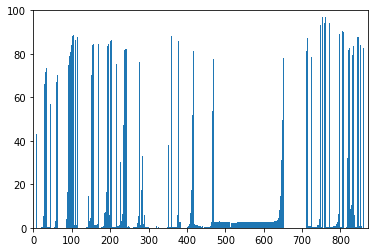

In [13]:
updated_deleted90 = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                              threshold=0.9, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts90 = np.count_nonzero(updated_deleted90=="X",axis=0)
formerly_filled_counts90 = np.count_nonzero(updated_deleted90!="-",axis=0)
print(updated_deleted90.shape, deleted_counts90.shape, formerly_filled_counts90.shape)

updated_deleted70 = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                              threshold=0.7, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts70 = np.count_nonzero(updated_deleted70=="X",axis=0)
formerly_filled_counts70 = np.count_nonzero(updated_deleted70!="-",axis=0)


updated_deleted50 = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                              threshold=0.5, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts50 = np.count_nonzero(updated_deleted50=="X",axis=0)
formerly_filled_counts50 = np.count_nonzero(updated_deleted50!="-",axis=0)
 
updated_deleted20 = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                              threshold=0.2, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts20 = np.count_nonzero(updated_deleted20=="X",axis=0)
formerly_filled_counts20 = np.count_nonzero(updated_deleted20!="-",axis=0)

updated_deleted100 = modifyAlignmentBasedOnPairwiseFrequencies(alignmentMatrix, frequenciesNorm, 
                                                              threshold=1, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts100 = np.count_nonzero(updated_deleted100=="X",axis=0)
formerly_filled_counts100 = np.count_nonzero(updated_deleted100!="-",axis=0)

plt.bar(range(len(formerly_filled_counts20)), 100 * formerly_filled_counts20/alignmentMatrix.shape[0], align='edge', width=1)
plt.xlim(0, alignment_len)
plt.ylim(0, 100)

Text(0, 0.5, 'Fraction Below Threshold')

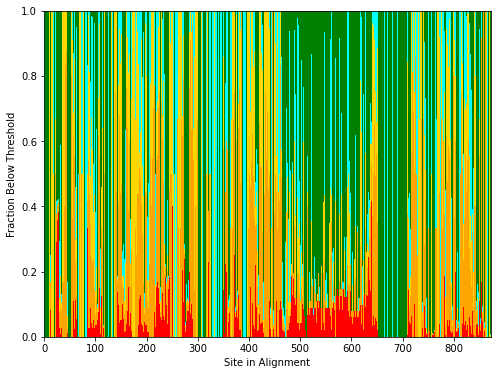

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))


ax.set_facecolor("limegreen")
#plt.bar(range(len(deleted_counts90)), deleted_counts90 / num_seqs, color="cyan")
#plt.bar(range(len(deleted_counts70)), deleted_counts70 / num_seqs, color="green")
#plt.bar(range(len(deleted_counts50)), deleted_counts50 / num_seqs, color="gold")
#plt.bar(range(len(deleted_counts20)), deleted_counts20 / num_seqs, color="red")

formerly_filled_counts = formerly_filled_counts100.copy()
formerly_filled_counts[formerly_filled_counts==0] = 1
plt.bar(range(len(deleted_counts100)), deleted_counts100 / formerly_filled_counts, color="green",width=1, align='edge')
plt.bar(range(len(deleted_counts90)), deleted_counts90 / formerly_filled_counts, color="cyan",width=1, align='edge')
plt.bar(range(len(deleted_counts70)), deleted_counts70 / formerly_filled_counts, color="gold",width=1, align='edge')
plt.bar(range(len(deleted_counts50)), deleted_counts50 / formerly_filled_counts, color="orange",width=1, align='edge')
plt.bar(range(len(deleted_counts20)), deleted_counts20 / formerly_filled_counts, color="red",width=1, align='edge')
#plt.bar(range(len(deleted_counts20)), [int(x < 0.01*alignmentMatrix.shape[0]) for x in formerly_filled_counts], color="black", alpha=0.5)
plt.xlim(0, alignment_len)
plt.ylim(0, 1)

plt.xlabel("Site in Alignment")
plt.ylabel("Fraction Below Threshold")

In [15]:
if run_name + '_300x_heatmaps.npz' not in os.listdir():
    heatMaps = []
    indices = []
else:
    container = np.load(run_name + '_300x_heatmaps.npz')
    heatMaps = [container[key] for key in container]
    indices = list(range(len(heatMaps)))
    
if run_name + "_realigned_300x.afa" not in os.listdir():
    realignment_seq_dict = {}
    out = open(run_name + "_realigned_300x.afa", 'w')
    out.close()
    realignments = []
else:
    realignment_seq_dict = file_to_seq_dict(run_name + "_realigned_300x.afa")
    sequence_matrix_2, labels_2 = seq_dict_to_matrix(realignment_seq_dict)
    paths = [get_seq_to_align(seq, sequence_matrix_2) for seq in range(len(realignment_seq_dict))]
    scores = [[heatMaps[seq][s,paths[seq][s]] for s in range(len(paths[seq]))] for seq in range(len(paths))]
    realignments = [[(np.sum(scores[seq]), scores[seq], paths[seq])] for seq in range(len(paths))]

prealignments = [get_seq_to_align(seq, sequence_matrix) for seq in range(sequence_matrix.shape[0])]
#print(realignments[0][2], '\n', prealignments[0])
#print(realignments[0])
print("Alignment match matrices:", len(heatMaps), "/", len(frequenciesNorm), 
      "\nSequences realigned:", len(realignment_seq_dict), "| Length:", 
      set([len(realignment_seq_dict[x]) for x in realignment_seq_dict]))

Alignment match matrices: 1860 / 1860 
Sequences realigned: 1860 | Length: {872}


In [16]:
print(len(heatMaps), len(indices))
print(indices[:10], indices[-10:])
for x in range(len(heatMaps), len(frequenciesNorm)):
    clear_output(wait=True)
    print(len(heatMaps),"/",len(frequencies), round(len(heatMaps)/len(frequencies)*100, 1), "%")
    print(indices[:10], indices[-10:])
    if x in indices:
        continue
    heatMaps.append(get_match_matrix(frequenciesNorm[x], alignmentFrequencies, metric=cos_vector_angle_exclude))
    indices.append(y)


1860 1860
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859]


In [17]:
np.savez(run_name + '_300x_heatmaps.npz', *heatMaps)

In [18]:
for i in range(len(realignments), len(heatMaps)):
    seq_to_align = get_seq_to_align(i, sequence_matrix)
    realignments.append(align_sequence_to_matrix(heatMaps[i], pre_alignment=seq_to_align, verbose=True))

In [19]:
if run_name + "_realigned_300x.afa" not in os.listdir():
    realignmentMatrix = np.empty((len(realignments), sequence_matrix.shape[1]), dtype=object)
    for i in range(len(realignments)):
        #print(i)
        realignment = realignments[i][0][2]
        #print(realignment)
        sequence = "".join((sequence_matrix[i, :])).replace("-","")
        aligned_sequence = [sequence[realignment.index(x)] if x in realignment else "-" for x in range(sequence_matrix.shape[1])]
        if len("".join(aligned_sequence).replace("-", "")) != len(realignment):
            print(realignment)
        realignmentMatrix[i,:] = aligned_sequence
    print(realignmentMatrix.shape)
    realigned_seq_dict = matrix_to_dictionary(realignmentMatrix, labels)
    with open(run_name + "_realigned_300x.afa", 'w') as out:
        for seq in realigned_seq_dict:
            out.write(">" + seq + "\n" + realigned_seq_dict[seq] + "\n")

In [21]:
#realignments = [] 
seqs_to_align = [get_seq_to_align(seq, sequence_matrix) for seq in range(len(realignments))]
alignment_scores = [[heatMaps[seq][s, seqs_to_align[seq][s]] for s in range(len(seqs_to_align[seq]))] 
                    for seq in range(len(realignments))]

rando = np.random.randint(len(realignments))
seq_to_align = seqs_to_align[rando]
alignment_score = np.sum(alignment_scores[rando])

print("Sequence:       ", rando+1, "/", len(realignments))
print("Alignment score:", round(alignment_score, 2), "/", len(realignments[rando][0][2]))
print("Refined scores:", [round(x[0],2) for x in realignments[rando]])

Sequence:        350 / 1860
Alignment score: 56.39 / 86
Refined scores: [72.28]


Slope: 0.4799136834170503 Intercept: 0.49104040555044215
Alignment mean: 0.7985977256555519 Refined mean: 0.8742983816382771


Text(0, 0.5, 'Realignment Pairwise Score')

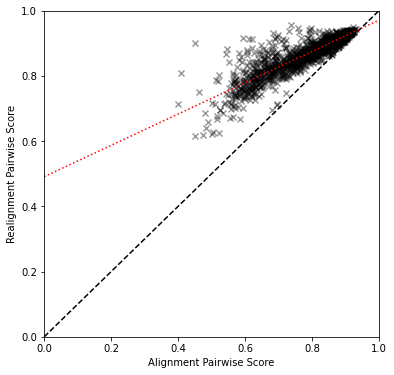

In [22]:
#print([seq[0][0] for seq in realignments])
#print(alignment_scores)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter([np.sum(x)/len(x) for x in alignment_scores], [seq[0][0]/len(seq[0][1]) for seq in realignments], marker="x", alpha=0.4, color="black")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot(np.linspace(0,1,3), np.linspace(0,1,3), color="black",zorder=-1, linestyle="--")
m, b = np.polyfit([np.sum(x)/len(x) for x in alignment_scores], [seq[0][0]/len(seq[0][1]) for seq in realignments], 1)
ax.plot (np.linspace(0,1,100), [m*x + b for x in np.linspace(0,1,100)],color="red", alpha=1, linestyle=":")
print("Slope:", m, "Intercept:", b)
print("Alignment mean:", np.mean([np.sum(x)/len(x) for x in alignment_scores]), 
      "Refined mean:", np.mean([seq[0][0]/len(seq[0][1]) for seq in realignments]))
ax.set_xlabel("Alignment Pairwise Score")
ax.set_ylabel("Realignment Pairwise Score")

(1860, 872) (872,) (872,)


(0.0, 100.0)

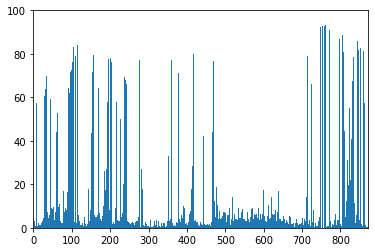

In [23]:
updated_deleted90 = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                              threshold=0.9, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts90 = np.count_nonzero(updated_deleted90=="X",axis=0)
formerly_filled_counts90 = np.count_nonzero(updated_deleted90!="-",axis=0)
print(updated_deleted90.shape, deleted_counts90.shape, formerly_filled_counts90.shape)

updated_deleted70 = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                              threshold=0.7, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts70 = np.count_nonzero(updated_deleted70=="X",axis=0)
formerly_filled_counts70 = np.count_nonzero(updated_deleted70!="-",axis=0)


updated_deleted50 = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                              threshold=0.5, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts50 = np.count_nonzero(updated_deleted50=="X",axis=0)
formerly_filled_counts50 = np.count_nonzero(updated_deleted50!="-",axis=0)
 
updated_deleted20 = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                              threshold=0.2, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts20 = np.count_nonzero(updated_deleted20=="X",axis=0)
formerly_filled_counts20 = np.count_nonzero(updated_deleted20!="-",axis=0)

updated_deleted100 = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                              threshold=1, delete_bad=True, 
                                                              metric=cos_vector_angle_exclude)
deleted_counts100 = np.count_nonzero(updated_deleted100=="X",axis=0)
formerly_filled_counts100 = np.count_nonzero(updated_deleted100!="-",axis=0)


plt.bar(range(len(formerly_filled_counts20)), 100 * formerly_filled_counts20/sequence_matrix_2.shape[0], align='edge', width=1)
plt.xlim(0, alignment_len)
plt.ylim(0, 100)

Text(0, 0.5, 'Fraction Below Threshold')

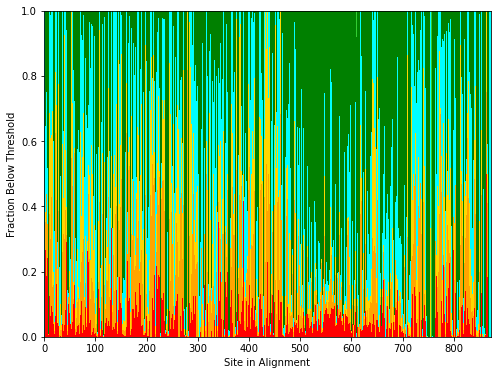

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor("limegreen")

formerly_filled_counts = formerly_filled_counts100.copy()
formerly_filled_counts[formerly_filled_counts==0] = 1
plt.bar(range(len(deleted_counts100)), deleted_counts100 / formerly_filled_counts, color="green",width=1, align='edge')
plt.bar(range(len(deleted_counts90)), deleted_counts90 / formerly_filled_counts, color="cyan",width=1, align='edge')
plt.bar(range(len(deleted_counts70)), deleted_counts70 / formerly_filled_counts, color="gold",width=1, align='edge')
plt.bar(range(len(deleted_counts50)), deleted_counts50 / formerly_filled_counts, color="orange",width=1, align='edge')
plt.bar(range(len(deleted_counts20)), deleted_counts20 / formerly_filled_counts, color="red",width=1, align='edge')
#plt.bar(range(len(deleted_counts20)), [int(x < 0.01*alignmentMatrix.shape[0]) for x in formerly_filled_counts], color="black", alpha=0.5)
plt.xlim(0, alignment_len)
plt.ylim(0, 1)

plt.xlabel("Site in Alignment")
plt.ylabel("Fraction Below Threshold")

In [25]:
updated_alignmentMatrix = modifyAlignmentBasedOnPairwiseFrequencies(sequence_matrix_2, frequenciesNorm, 
                                                                    threshold=0.5, delete_bad=True)

In [26]:
updated_seqDict = matrix_to_dictionary(updated_alignmentMatrix, labels)
with open(run_name + "_realigned_trimmed_50_300x.afa", 'w') as out:
    for seq in updated_seqDict:
        out.write(">" + seq + "\n" + updated_seqDict[seq] + "\n")

In [27]:
realignmentFrequencies = get_aa_frequencies_by_site(sequence_matrix_2, alphabet=alphabet)

if run_name + '_realigned_300x_heatmaps.npz' not in os.listdir():
    reHeatMaps = []
    reIndices = []
else:
    container = np.load(run_name + '_realigned_300x_heatmaps.npz')
    reHeatMaps = [container[key] for key in container]
    reIndices = list(range(len(reHeatMaps)))

In [29]:
print(len(reHeatMaps), len(reIndices))
#print(indices[:10], indices[-10:])

for x in range(len(reHeatMaps), len(frequenciesNorm)):
    clear_output(wait=True)
    print(len(reHeatMaps),"/",len(frequencies), round(len(reHeatMaps)/len(frequencies)*100, 1), "%")
    print(reIndices[:min(len(indices),10)], reIndices[max(-10, -len(indices)):])
    if x in reIndices:
        continue
    match_matrix = get_match_matrix(frequenciesNorm[x], realignmentFrequencies, metric=cos_vector_angle_exclude)
    reHeatMaps.append(match_matrix)
    reIndices.append(x)


557 / 1860 29.9 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [547, 548, 549, 550, 551, 552, 553, 554, 555, 556]


KeyboardInterrupt: 

In [32]:
np.savez(run_name + '_realigned_300x_heatmaps.npz', *reHeatMaps)

Mean Score Before Realignment:           0.17653700432425506
Mean Score After Realignment:            0.1563283932687297
R^2 =                                    0.797112772837174
Mean Realigned Score Before Realignment: 0.8648392108250936
Mean Realigned Score After Realignment:  0.8697836476788251
R^2 =                                    0.8639724620693268
Mean Unaligned Score Before Realignment: 0.8084376434496175
Mean Unaligned Score After Realignment:  0.7891817549250452
R^2 =                                    0.9478905460283296


Text(0, 0.5, 'Score in new alignment')

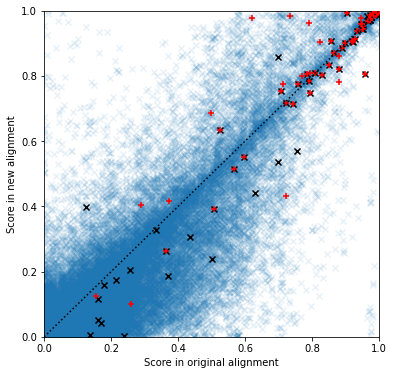

In [31]:
fig, ax = plt.subplots(figsize=(6,6))

i = np.random.randint(0, len(reHeatMaps))
rando = indices[i]
ax.scatter(heatMaps[rando].flatten(), reHeatMaps[rando].flatten(),alpha=0.1,marker="x")
alignment_scores = [[heatMaps[seq][s, seqs_to_align[seq][s]] for s in range(len(seqs_to_align[seq]))] 
                    for seq in range(len(realignments))]

heatmap = heatMaps[rando]
reheatmap = reHeatMaps[rando]
realignment = realignments[rando][0]
#print(realignment)
path = realignment[2]
scores_in_orig = realignment[1]
scores_in_new = [reheatmap[s,path[s]] for s in range(len(path))]
ax.scatter(scores_in_orig,scores_in_new,marker="+",color="red",zorder=15)

original_path = seqs_to_align[rando]
original_score = alignment_scores[rando]
original_align_in_realign = [reheatmap[s,original_path[s]] for s in range(len(original_path))]
ax.scatter(original_score,original_align_in_realign,marker="x",color="black")

ax.plot(range(0,2), range(0,2),zorder=16,color="black",linestyle=":")


print("Mean Score Before Realignment:          ", np.mean(heatmap))
print("Mean Score After Realignment:           ", np.mean(reheatmap))
print("R^2 =                                   ",np.corrcoef(heatmap.flatten(), reheatmap.flatten())[0,1]**2)

print("Mean Realigned Score Before Realignment:", np.mean(scores_in_orig))
print("Mean Realigned Score After Realignment: ", np.mean(scores_in_new))
print("R^2 =                                   ",np.corrcoef(scores_in_orig, scores_in_new)[0,1]**2)

print("Mean Unaligned Score Before Realignment:", np.mean(original_score))
print("Mean Unaligned Score After Realignment: ", np.mean(original_align_in_realign))
print("R^2 =                                   ",np.corrcoef(original_score, original_align_in_realign)[0,1]**2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("Score in original alignment")
ax.set_ylabel("Score in new alignment")

R^2 =  0.9781787268518037
R^2 no gaps =  0.9058922878353878


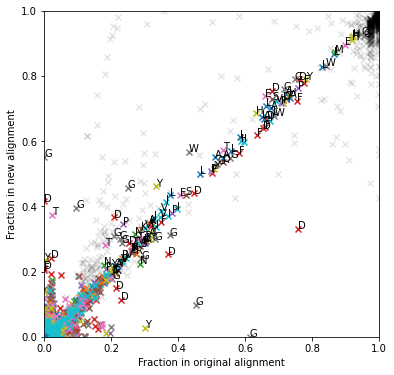

In [32]:
fig, ax = plt.subplots(figsize=(6,6))

for i in range(0, realignmentFrequencies.shape[0]):
    x, y = alignmentFrequencies[i,:], realignmentFrequencies[i,:]
    if i == 0:
        ax.scatter(x, y,label=inverse_alphabet[i],marker="x",color="black", alpha=0.1,zorder=-100)
    else:
        ax.scatter(x, y,label=inverse_alphabet[i],marker="x",alpha=1)
        for a,b in zip(x,y):
            if max(a,b) > 0.2:
                ax.annotate(inverse_alphabet[i],  xy=(a, b))
#ax.legend(ncol=3)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel("Fraction in original alignment")
ax.set_ylabel("Fraction in new alignment")

print("R^2 = ",np.corrcoef(alignmentFrequencies.flatten(), realignmentFrequencies.flatten())[0,1]**2)
print("R^2 no gaps = ", np.corrcoef(alignmentFrequencies[1:,:].flatten(), realignmentFrequencies[1:,:].flatten())[0,1]**2)
